# Import & Prepare data:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Split data:

In [ ]:
import os
import shutil
import random

# Paths
source_dir = "CHD_images"
target_dir = "CHD_split"
splits = {'train': 0.7, 'val': 0.2, 'test': 0.1}

# Create split directories
for split in splits:
    for class_name in os.listdir(source_dir):
        os.makedirs(os.path.join(target_dir, split, class_name), exist_ok=True)

# For each class folder
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    images = os.listdir(class_path)
    random.shuffle(images)

    total = len(images)
    train_end = int(splits['train'] * total)
    val_end = train_end + int(splits['val'] * total)

    train_imgs = images[:train_end]
    val_imgs = images[train_end:val_end]
    test_imgs = images[val_end:]

    # Copy files
    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(target_dir, 'train', class_name, img))
    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(target_dir, 'val', class_name, img))
    for img in test_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(target_dir, 'test', class_name, img))

print("✅ Dataset split into train/val/test folders.")


✅ Dataset split into train/val/test folders.


# Train without GANs:

## With image augmentation and CLAHE preprocessing:

In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from tqdm import tqdm

# --- CLAHE and Augmentations ---
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
augment = A.Compose([
    A.HorizontalFlip(p=0.7),
    A.Rotate(limit=10, p=0.8),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomGamma(p=0.5),
    A.ElasticTransform(p=0.3),
])

def apply_clahe(image_rgb):
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    enhanced = clahe.apply(gray)
    return cv2.cvtColor(enhanced, cv2.COLOR_GRAY2RGB)

def preprocess_and_augment_image(image_path, n_augmented_per_image=1):
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    clahe_img = apply_clahe(image_rgb)
    augmented_images = [augment(image=clahe_img)["image"] for _ in range(n_augmented_per_image)]
    return image_rgb, clahe_img, augmented_images

def visualize_sample_images(folder_path, n_samples=3, n_augmented_per_image=1):
    print("📷 Displaying CLAHE + Augmentation sample images...")
    all_images = []
    for subfolder in os.listdir(folder_path):
        sub_path = os.path.join(folder_path, subfolder)
        images = [os.path.join(sub_path, img) for img in os.listdir(sub_path)][:n_samples]
        all_images.extend(images)

    for path in all_images:
        original, clahe_img, augmented_list = preprocess_and_augment_image(path, n_augmented_per_image)
        for idx, aug in enumerate(augmented_list):
            fig, axes = plt.subplots(1, 3, figsize=(12, 4))
            axes[0].imshow(original)
            axes[0].set_title("Original")
            axes[1].imshow(clahe_img)
            axes[1].set_title("CLAHE")
            axes[2].imshow(aug)
            axes[2].set_title(f"Augmented {idx+1}")
            for ax in axes:
                ax.axis("off")
            plt.tight_layout()
            plt.show()

def preprocess_dataset(input_folder, output_folder, n_augmented_per_image=1):
    os.makedirs(output_folder, exist_ok=True)

    for class_name in os.listdir(input_folder):
        class_input_path = os.path.join(input_folder, class_name)
        class_output_path = os.path.join(output_folder, class_name)
        os.makedirs(class_output_path, exist_ok=True)

        for img_name in tqdm(os.listdir(class_input_path), desc=f"Processing {class_name}"):
            img_path = os.path.join(class_input_path, img_name)
            _, _, augmented_list = preprocess_and_augment_image(img_path, n_augmented_per_image)

            # Save all augmented versions
            for idx, aug_img in enumerate(augmented_list):
                new_name = f"{os.path.splitext(img_name)[0]}_aug{idx+1}.jpg"
                save_path = os.path.join(class_output_path, new_name)
                cv2.imwrite(save_path, cv2.cvtColor(aug_img, cv2.COLOR_RGB2BGR))

    print(f"✅ Finished augmenting {input_folder} → {output_folder}")


n_aug = 10  # generate N augmented versions per image
# Preview a few samples
# visualize_sample_images("CHD_split/train", n_samples=2, n_augmented_per_image=n_aug)

# Apply to full dataset (uncomment to run)
preprocess_dataset("CHD_split/train", "CHD_processed/train", n_augmented_per_image=n_aug)
preprocess_dataset("CHD_split/val", "CHD_processed/val", n_augmented_per_image=n_aug)


Processing VSD: 100%|██████████| 147/147 [01:10<00:00,  2.09it/s]


✅ Finished augmenting CHD_split/train → CHD_processed/train


Processing VSD: 100%|██████████| 42/42 [00:19<00:00,  2.12it/s]

✅ Finished augmenting CHD_split/val → CHD_processed/val


In [ ]:
# Save data to drive
!cp -r /content/CHD_processed /content/drive/MyDrive/kaggle

In [ ]:
!zip CHD_split.zip CHD_split/*/*/*

In [ ]:
!cp /content/CHD_split.zip /content/drive/MyDrive/kaggle

In [ ]:
import os
import shutil
from tqdm import tqdm

def combine_images(raw_folder, augmented_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)

    class_names = os.listdir(raw_folder)
    for class_name in class_names:
        raw_class_path = os.path.join(raw_folder, class_name)
        aug_class_path = os.path.join(augmented_folder, class_name)
        out_class_path = os.path.join(output_folder, class_name)

        os.makedirs(out_class_path, exist_ok=True)

        # Copy raw CLAHE images
        for file_name in tqdm(os.listdir(raw_class_path), desc=f"Copying raw {class_name}"):
            src = os.path.join(raw_class_path, file_name)
            dst = os.path.join(out_class_path, file_name)
            shutil.copy(src, dst)

        # Copy augmented images
        for file_name in tqdm(os.listdir(aug_class_path), desc=f"Copying augmented {class_name}"):
            src = os.path.join(aug_class_path, file_name)
            dst = os.path.join(out_class_path, file_name)
            shutil.copy(src, dst)

    print(f"✅ Combined raw + augmented images into {output_folder}")

# Example usage
combine_images(
    raw_folder="CHD_split/train",         # raw CLAHE-enhanced images (originals)
    augmented_folder="CHD_processed/train",  # augmented images
    output_folder="CHD_final/train"       # combined destination
)

combine_images(
    raw_folder="CHD_split/val",
    augmented_folder="CHD_processed/val",
    output_folder="CHD_final/val"
)


Copying augmented VSD: 100%|██████████| 1470/1470 [00:03<00:00, 421.56it/s]


✅ Combined raw + augmented images into CHD_final/train


Copying augmented VSD: 100%|██████████| 420/420 [00:00<00:00, 441.46it/s]

✅ Combined raw + augmented images into CHD_final/val


In [ ]:
# Check number of images per class before combine
base = 'CHD_processed'
total = 0

for part in os.listdir(base):
  path = os.path.join(base,part)
  for cla in os.listdir(path):
    sub = os.path.join(path,cla)
    num_imgs = len(os.listdir(sub))
    total = total+num_imgs

    print(f"{part}:{cla}:{num_imgs}")

print("\nTOTAL:",total)

train:PDA:1510
train:ASD:1350
train:Normal:1450
train:VSD:1470
val:PDA:430
val:ASD:380
val:Normal:410
val:VSD:420

TOTAL: 7420


In [ ]:
# Check number of images per class after Augmentation
base = 'CHD_final'
total = 0
for part in os.listdir(base):
  path = os.path.join(base,part)
  for cla in os.listdir(path):
    sub = os.path.join(path,cla)
    num_imgs = len(os.listdir(sub))
    total+=num_imgs
    print(f"{part}:{cla}:{num_imgs}")

print("\nTOTAL:",total)

train:PDA:1661
train:ASD:1485
train:Normal:1595
train:VSD:1617
val:PDA:473
val:ASD:418
val:Normal:451
val:VSD:462

TOTAL: 8162


# Train ConvNext without GANs:

[1/10] Train Acc: 0.520 | Val Acc: 0.519 | Train Loss: 0.6702 | Val Loss: 0.7451
[2/10] Train Acc: 0.881 | Val Acc: 0.642 | Train Loss: 0.1577 | Val Loss: 1.0075
[3/10] Train Acc: 0.979 | Val Acc: 0.631 | Train Loss: 0.0296 | Val Loss: 1.4658
[4/10] Train Acc: 0.984 | Val Acc: 0.644 | Train Loss: 0.0255 | Val Loss: 1.3882
[5/10] Train Acc: 1.000 | Val Acc: 0.650 | Train Loss: 0.0017 | Val Loss: 1.5299
[6/10] Train Acc: 1.000 | Val Acc: 0.647 | Train Loss: 0.0014 | Val Loss: 1.5327
[7/10] Train Acc: 1.000 | Val Acc: 0.644 | Train Loss: 0.0013 | Val Loss: 1.5165
[8/10] Train Acc: 1.000 | Val Acc: 0.644 | Train Loss: 0.0013 | Val Loss: 1.5070
[9/10] Train Acc: 1.000 | Val Acc: 0.643 | Train Loss: 0.0013 | Val Loss: 1.5028
[10/10] Train Acc: 1.000 | Val Acc: 0.643 | Train Loss: 0.0013 | Val Loss: 1.5016


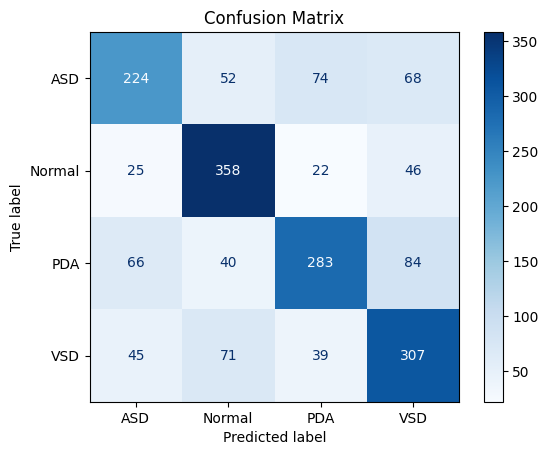

ASD: 53.59%
Normal: 79.38%
PDA: 59.83%
VSD: 66.45%


In [ ]:
## convnext Transformer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import timm
from collections import Counter
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- Settings ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
lr = 3e-4
batch_size = 32
data_dir = "/content/CHD_final"
balance_classes = False
save_path = "/content/best_convnext_model.pth"

# --- Focal Loss ---
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean', label_smoothing=0.05):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        log_probs = nn.functional.log_softmax(inputs, dim=-1)
        probs = torch.exp(log_probs)
        if self.label_smoothing > 0:
            n_classes = inputs.size(1)
            with torch.no_grad():
                true_dist = torch.zeros_like(inputs)
                true_dist.fill_(self.label_smoothing / (n_classes - 1))
                true_dist.scatter_(1, targets.unsqueeze(1), 1 - self.label_smoothing)
        else:
            true_dist = nn.functional.one_hot(targets, num_classes=inputs.size(1)).float()
        pt = (probs * true_dist).sum(dim=1)
        log_pt = (log_probs * true_dist).sum(dim=1)
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            loss = -alpha_t * (1 - pt) ** self.gamma * log_pt
        else:
            loss = -(1 - pt) ** self.gamma * log_pt
        return loss.mean()

# --- Transforms ---
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Datasets & Loaders ---
train_ds = datasets.ImageFolder(f"{data_dir}/train", transform=train_transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val", transform=val_transform)

if balance_classes:
    class_counts = Counter([label for _, label in train_ds])
    class_weights = [1.0 / class_counts[label] for _, label in train_ds]
    sampler = torch.utils.data.WeightedRandomSampler(class_weights, len(class_weights))
    train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler)
else:
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

class_names = train_ds.classes
num_classes = len(class_names)

# --- Model ---
model = timm.create_model('convnext_base', pretrained=True, num_classes=num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

alpha = torch.tensor([1.5, 1.0, 0.8, 1.5]).to(device)
criterion = FocalLoss(alpha=alpha, gamma=2.0, label_smoothing=0.05)

# --- Training Loop ---
best_val_acc = 0
for epoch in range(num_epochs):
    model.train()
    all_labels, all_preds = [], []
    total_loss = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        all_labels += labels.cpu().tolist()
        all_preds += logits.argmax(1).cpu().tolist()

    train_acc = accuracy_score(all_labels, all_preds)
    train_loss = total_loss / len(train_loader.dataset)

    model.eval()
    all_labels, all_preds = [], []
    total_loss = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            loss = criterion(logits, labels)
            total_loss += loss.item() * imgs.size(0)
            all_labels += labels.cpu().tolist()
            all_preds += logits.argmax(1).cpu().tolist()

    val_acc = accuracy_score(all_labels, all_preds)
    val_loss = total_loss / len(val_loader.dataset)
    scheduler.step()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)

    print(f"[{epoch+1}/{num_epochs}] "
          f"Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f} | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

# --- Load and Evaluate Best Model ---
model.load_state_dict(torch.load(save_path))
model.eval()

all_labels, all_preds = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        all_labels += labels.cpu().tolist()
        all_preds += logits.argmax(1).cpu().tolist()

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# --- Per-Class Accuracy ---
cm_diag = cm.diagonal()
cm_sum = cm.sum(axis=1)
per_class_acc = cm_diag / cm_sum
for idx, class_name in enumerate(class_names):
    print(f"{class_name}: {per_class_acc[idx]*100:.2f}%")


In [ ]:
!cp /content/best_convnext_model.pth /content/drive/MyDrive/kaggle/without_GANs_convnext.pth

# Train with ConvNext with GANs

## Generate GAN images:

### Initialize the model

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


✅ Resumed from checkpoint at epoch 1000
CHD dataset class mapping: {'ASD': 0, 'Normal': 1, 'PDA': 2, 'VSD': 3}


<ipython-input-5-167b09aef035>:49: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.2),


[Epoch 1000] D loss: 0.1495, G loss: 4.7897


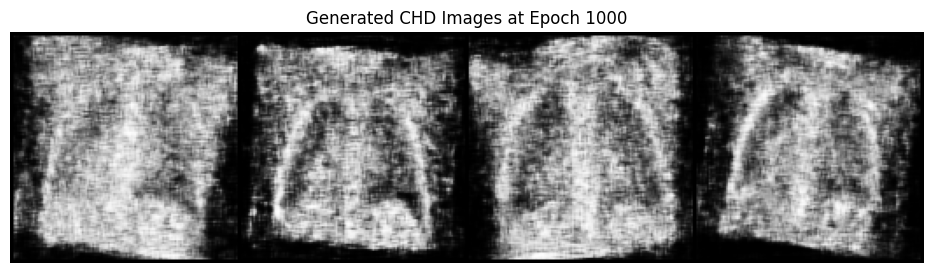

In [ ]:
# ===============================
# 🔧 Setup
# ===============================
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2

# ===============================
# 🧠 Config
# ===============================
img_size = 128
channels = 1
img_shape = (channels, img_size, img_size)
n_classes = 4
latent_dim = 100
batch_size = 64
n_epochs = 1001
lr = 0.0002
b1 = 0.5
b2 = 0.999
sample_interval = 1

# ===============================
# 📁 Save Path
# ===============================
save_dir = "/content/drive/MyDrive/kaggle/GANs"
os.makedirs(save_dir, exist_ok=True)

# ===============================
# 🔄 CLAHE + Augment Transform
# ===============================
class CLAHEAugmentTransform:
    def __init__(self):
        self.aug = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.Rotate(limit=10, p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.RandomGamma(p=0.3),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=30, p=0.2),
            A.Resize(img_size, img_size),
            A.Normalize(mean=[0.5], std=[0.5]),
            ToTensorV2()
        ])

    def __call__(self, img_pil):
        # Convert to grayscale → apply CLAHE
        img = np.array(img_pil.convert("L"))  # shape: (H, W)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        clahe_img = clahe.apply(img)
        clahe_img = np.expand_dims(clahe_img, axis=-1)  # shape: (H, W, 1)
        augmented = self.aug(image=clahe_img)
        return augmented['image']

# ===============================
# 🧪 Generator
# ===============================
class Generator(nn.Module):
    def __init__(self, latent_dim, n_classes, img_shape):
        super().__init__()
        self.label_emb = nn.Embedding(n_classes, n_classes)
        self.init_size = img_shape[1] // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim + n_classes, 128 * self.init_size ** 2))
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, channels, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((noise, self.label_emb(labels)), -1)
        out = self.l1(gen_input)
        out = out.view(out.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(out)
        return img

# ===============================
# ❌ Discriminator
# ===============================
class Discriminator(nn.Module):
    def __init__(self, n_classes, img_shape):
        super().__init__()
        self.label_emb = nn.Embedding(n_classes, n_classes)
        self.model = nn.Sequential(
            nn.Linear(n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        d_in = torch.cat((img.view(img.size(0), -1), self.label_emb(labels)), -1)
        validity = self.model(d_in)
        return validity

# ===============================
# 🚀 Training Setup
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = Generator(latent_dim, n_classes, img_shape).to(device)
discriminator = Discriminator(n_classes, img_shape).to(device)
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))
adversarial_loss = nn.BCELoss()

# ===============================
# ♻️ Resume Checkpoint
# ===============================
start_epoch = 0
best_g_loss = float("inf")
checkpoint_path = os.path.join(save_dir, "gan_checkpoint.pth")
best_model_path = os.path.join(save_dir, "best_generator.pth")

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    generator.load_state_dict(checkpoint["generator_state_dict"])
    discriminator.load_state_dict(checkpoint["discriminator_state_dict"])
    optimizer_G.load_state_dict(checkpoint["optimizer_G_state_dict"])
    optimizer_D.load_state_dict(checkpoint["optimizer_D_state_dict"])
    start_epoch = checkpoint["epoch"] + 1
    best_g_loss = checkpoint.get("best_g_loss", best_g_loss)
    print(f"✅ Resumed from checkpoint at epoch {start_epoch}")

# ===============================
# 🖼️ Dataset Loader
# ===============================
transform = CLAHEAugmentTransform()
dataset = datasets.ImageFolder(root="/content/CHD_images", transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
print("CHD dataset class mapping:", dataset.class_to_idx)

# ===============================
# 🔁 Training Loop
# ===============================
for epoch in range(start_epoch, n_epochs):
    for i, (imgs, labels) in enumerate(dataloader):
        imgs, labels = imgs.to(device), labels.to(device)
        valid = torch.ones(imgs.size(0), 1).to(device)
        fake = torch.zeros(imgs.size(0), 1).to(device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(imgs.size(0), latent_dim).to(device)
        gen_labels = torch.randint(0, n_classes, (imgs.size(0),)).to(device)
        gen_imgs = generator(z, gen_labels)
        g_loss = adversarial_loss(discriminator(gen_imgs, gen_labels), valid)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = adversarial_loss(discriminator(imgs, labels), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach(), gen_labels), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    # Logging
    print(f"[Epoch {epoch}] D loss: {d_loss.item():.4f}, G loss: {g_loss.item():.4f}")

    # Save Best Generator
    if g_loss.item() < best_g_loss:
        best_g_loss = g_loss.item()
        torch.save(generator.state_dict(), best_model_path)
        print(f"✅ Saved best generator to: {best_model_path}")

    # Save Checkpoint
    checkpoint = {
        "epoch": epoch,
        "generator_state_dict": generator.state_dict(),
        "discriminator_state_dict": discriminator.state_dict(),
        "optimizer_G_state_dict": optimizer_G.state_dict(),
        "optimizer_D_state_dict": optimizer_D.state_dict(),
        "best_g_loss": best_g_loss,
    }
    torch.save(checkpoint, checkpoint_path)

    # Visualize Output
    if epoch % sample_interval == 0:
        generator.eval()
        z = torch.randn(n_classes, latent_dim).to(device)
        label_input = torch.arange(0, n_classes).to(device)
        with torch.no_grad():
            gen_imgs = generator(z, label_input)
        grid = make_grid(gen_imgs, nrow=n_classes, normalize=True)
        plt.figure(figsize=(12, 3))
        plt.imshow(grid.permute(1, 2, 0).cpu())
        plt.title(f"Generated CHD Images at Epoch {epoch}")
        plt.axis("off")
        plt.show()
        generator.train()

### Generate and save the images:

In [ ]:
import os
import torch
from torchvision.utils import save_image
from tqdm import tqdm

# 🔧 Settings
num_images_per_class = 3000  # Change as needed
output_root = "/content/GANs_train/train"  # Target root directory
class_names = ["ASD", "PDA", "VSD", "Normal"]  # Match your dataset order

# Ensure generator is in eval mode
generator.eval()

# Create folders if they don’t exist
for class_name in class_names:
    os.makedirs(os.path.join(output_root, class_name), exist_ok=True)

# Generate and save images
for class_id, class_name in enumerate(class_names):
    print(f"🔄 Generating {num_images_per_class} images for class: {class_name}")
    for i in tqdm(range(num_images_per_class)):
        z = torch.randn(1, latent_dim).to(device)
        label = torch.tensor([class_id], dtype=torch.long).to(device)

        with torch.no_grad():
            gen_img = generator(z, label)
            gen_img = (gen_img + 1) / 2.0  # Denormalize

        save_path = os.path.join(output_root, class_name, f"{class_name}_{i:04}.png")
        save_image(gen_img.squeeze(0), save_path)

print("✅ All synthetic images generated and saved!")


🔄 Generating 3000 images for class: ASD


100%|██████████| 3000/3000 [00:22<00:00, 134.96it/s]


🔄 Generating 3000 images for class: PDA


100%|██████████| 3000/3000 [00:21<00:00, 137.22it/s]


🔄 Generating 3000 images for class: VSD


100%|██████████| 3000/3000 [00:22<00:00, 135.07it/s]


🔄 Generating 3000 images for class: Normal


100%|██████████| 3000/3000 [00:21<00:00, 139.80it/s]

✅ All synthetic images generated and saved!


In [ ]:
# Combine data
import os
import shutil
from tqdm import tqdm

# Source and destination root folders
src_root = "/content/CHD_processed/train"
dst_root = "/content/GANs_data/train"

# Loop through class subfolders
for class_name in os.listdir(src_root):
    src_class_dir = os.path.join(src_root, class_name)
    dst_class_dir = os.path.join(dst_root, class_name)

    # Create destination class folder if not exists
    os.makedirs(dst_class_dir, exist_ok=True)

    # Copy each image
    for filename in tqdm(os.listdir(src_class_dir), desc=f"Copying {class_name}"):
        src_file = os.path.join(src_class_dir, filename)
        dst_file = os.path.join(dst_class_dir, filename)

        # Avoid overwrite
        if not os.path.exists(dst_file):
            shutil.copy2(src_file, dst_file)

print("✅ All real training images copied to /content/GANs_data/train")


Copying VSD: 100%|██████████| 1470/1470 [00:04<00:00, 344.86it/s]

✅ All real training images copied to /content/GANs_data/train


In [ ]:
# Check number of images per class after combine
base = 'GANs_data'
total = 0

for part in os.listdir(base):
  path = os.path.join(base,part)
  for cla in os.listdir(path):
    sub = os.path.join(path,cla)
    num_imgs = len(os.listdir(sub))
    total = total+num_imgs

    print(f"{part}:{cla}:{num_imgs}")

print("\nTOTAL:",total)

train:PDA:4510
train:ASD:4350
train:Normal:4450
train:VSD:4470
val:PDA:430
val:ASD:380
val:Normal:410
val:VSD:420

TOTAL: 19420


## Train ConvNext as classifier:

In [ ]:
## convnext Transformer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import timm
from collections import Counter
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# --- Settings ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 10
lr = 3e-4
batch_size = 32
data_dir = "/content/GANs_data"
balance_classes = False
save_path = "/content/drive/MyDrive/kaggle/GANs_convnext.pth"

# --- Focal Loss ---
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean', label_smoothing=0.05):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        log_probs = nn.functional.log_softmax(inputs, dim=-1)
        probs = torch.exp(log_probs)
        if self.label_smoothing > 0:
            n_classes = inputs.size(1)
            with torch.no_grad():
                true_dist = torch.zeros_like(inputs)
                true_dist.fill_(self.label_smoothing / (n_classes - 1))
                true_dist.scatter_(1, targets.unsqueeze(1), 1 - self.label_smoothing)
        else:
            true_dist = nn.functional.one_hot(targets, num_classes=inputs.size(1)).float()
        pt = (probs * true_dist).sum(dim=1)
        log_pt = (log_probs * true_dist).sum(dim=1)
        if self.alpha is not None:
            alpha_t = self.alpha[targets]
            loss = -alpha_t * (1 - pt) ** self.gamma * log_pt
        else:
            loss = -(1 - pt) ** self.gamma * log_pt
        return loss.mean()

# --- Transforms ---
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- Datasets & Loaders ---
train_ds = datasets.ImageFolder(f"{data_dir}/train", transform=train_transform)
val_ds   = datasets.ImageFolder(f"{data_dir}/val", transform=val_transform)

if balance_classes:
    class_counts = Counter([label for _, label in train_ds])
    class_weights = [1.0 / class_counts[label] for _, label in train_ds]
    sampler = torch.utils.data.WeightedRandomSampler(class_weights, len(class_weights))
    train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=sampler)
else:
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

class_names = train_ds.classes
num_classes = len(class_names)

# --- Model ---
model = timm.create_model('convnext_base', pretrained=True, num_classes=num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs)

alpha = torch.tensor([1.5, 1.0, 0.8, 1.5]).to(device)
criterion = FocalLoss(alpha=alpha, gamma=2.0, label_smoothing=0.05)

# --- Training Loop ---
best_val_acc = 0
for epoch in range(num_epochs):
    model.train()
    all_labels, all_preds = [], []
    total_loss = 0

    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        all_labels += labels.cpu().tolist()
        all_preds += logits.argmax(1).cpu().tolist()

    train_acc = accuracy_score(all_labels, all_preds)
    train_loss = total_loss / len(train_loader.dataset)

    model.eval()
    all_labels, all_preds = [], []
    total_loss = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            logits = model(imgs)
            loss = criterion(logits, labels)
            total_loss += loss.item() * imgs.size(0)
            all_labels += labels.cpu().tolist()
            all_preds += logits.argmax(1).cpu().tolist()

    val_acc = accuracy_score(all_labels, all_preds)
    val_loss = total_loss / len(val_loader.dataset)
    scheduler.step()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), save_path)

    print(f"[{epoch+1}/{num_epochs}] "
          f"Train Acc: {train_acc:.3f} | Val Acc: {val_acc:.3f} | "
          f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

# --- Load and Evaluate Best Model ---
model.load_state_dict(torch.load(save_path))
model.eval()

all_labels, all_preds = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        all_labels += labels.cpu().tolist()
        all_preds += logits.argmax(1).cpu().tolist()

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# --- Per-Class Accuracy ---
cm_diag = cm.diagonal()
cm_sum = cm.sum(axis=1)
per_class_acc = cm_diag / cm_sum
for idx, class_name in enumerate(class_names):
    print(f"{class_name}: {per_class_acc[idx]*100:.2f}%")


[1/10] Train Acc: 0.565 | Val Acc: 0.605 | Train Loss: 0.5479 | Val Loss: 0.6235
[2/10] Train Acc: 0.801 | Val Acc: 0.618 | Train Loss: 0.2162 | Val Loss: 1.2261
[3/10] Train Acc: 0.906 | Val Acc: 0.649 | Train Loss: 0.1117 | Val Loss: 1.3166
[4/10] Train Acc: 0.958 | Val Acc: 0.607 | Train Loss: 0.0555 | Val Loss: 1.0939


KeyboardInterrupt: 

# Train ResNet:

## ResNet without GANs:

In [2]:
!cp -r /content/drive/MyDrive/kaggle/CHD_processed /content/

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


✅ ResNet50 ready — data loaded, model transferred to GPU.
💾 Saved new best model at epoch 1 with Val Acc: 69.02%
Epoch 1/10 | Train Acc: 84.81% | Val Acc: 69.02%
Epoch 2/10 | Train Acc: 97.25% | Val Acc: 68.23%
💾 Saved new best model at epoch 3 with Val Acc: 71.89%
Epoch 3/10 | Train Acc: 98.89% | Val Acc: 71.89%
Epoch 4/10 | Train Acc: 98.93% | Val Acc: 70.67%
💾 Saved new best model at epoch 5 with Val Acc: 73.29%
Epoch 5/10 | Train Acc: 98.77% | Val Acc: 73.29%
Epoch 6/10 | Train Acc: 99.38% | Val Acc: 69.51%
Epoch 7/10 | Train Acc: 99.01% | Val Acc: 72.93%
Epoch 8/10 | Train Acc: 99.38% | Val Acc: 69.82%
💾 Saved new best model at epoch 9 with Val Acc: 76.04%
Epoch 9/10 | Train Acc: 99.19% | Val Acc: 76.04%
Epoch 10/10 | Train Acc: 99.53% | Val Acc: 71.89%
✅ Best model loaded.


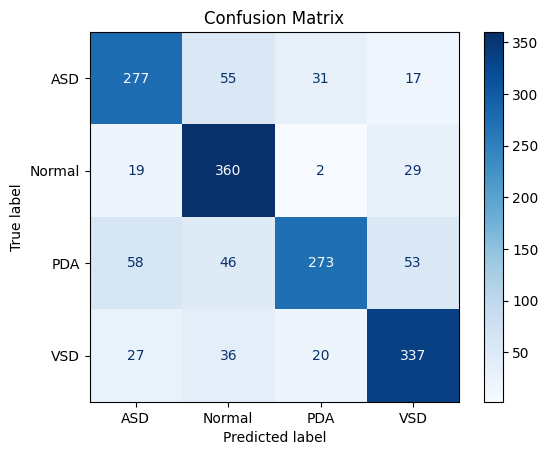

ASD: 72.89%
Normal: 87.80%
PDA: 63.49%
VSD: 80.24%


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import copy
import os

# ===============================
# 📁 Paths
# ===============================
base = "/content/CHD_processed"
train_data_path = os.path.join(base,"train")
val_data_path = os.path.join(base,"val")

# ===============================
# 🔄 Transforms
# ===============================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ===============================
# 📊 Datasets and Loaders
# ===============================
train_dataset = ImageFolder(train_data_path, transform=transform)
val_dataset = ImageFolder(val_data_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# ===============================
# 🧠 Model (ResNet50 + Transfer Learning)
# ===============================
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ===============================
# ⚙️ Training Setup
# ===============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 10

print("✅ ResNet50 ready — data loaded, model transferred to GPU.")

# ===============================
# 🔁 Training Loop with Validation
# ===============================
best_model_wts = copy.deepcopy(model.state_dict())
best_val_acc = 0.0

for epoch in range(epochs):
    model.train()
    train_true, train_pred = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, 1)
        train_true.extend(labels.cpu().numpy())
        train_pred.extend(preds.cpu().numpy())

    train_acc = accuracy_score(train_true, train_pred)

    # Validation phase
    model.eval()
    val_true, val_pred = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, 1)
            val_true.extend(labels.cpu().numpy())
            val_pred.extend(preds.cpu().numpy())

    val_acc = accuracy_score(val_true, val_pred)

    if val_acc > best_val_acc:
      best_val_acc = val_acc
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, "/content/drive/MyDrive/kaggle/resnet50_chd_model.pth")
      print(f"💾 Saved new best model at epoch {epoch+1} with Val Acc: {val_acc*100:.2f}%")

    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")

# ===============================
# 💾 Load Best Model
# ===============================
model.load_state_dict(best_model_wts)
print("✅ Best model loaded.")

# ===============================
# 📈 Evaluation & Confusion Matrix
# ===============================
model.eval()
val_true, val_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, 1)
        val_true.extend(labels.cpu().numpy())
        val_pred.extend(preds.cpu().numpy())

# Confusion Matrix
class_names = train_dataset.classes
cm = confusion_matrix(val_true, val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Per-class Accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for class_name, acc in zip(class_names, per_class_acc):
    print(f"{class_name}: {acc*100:.2f}%")


## ResNet with GANs:

In [3]:
!cp /content/drive/MyDrive/kaggle/generated_chd_images.zip /content/
!unzip -q generated_chd_images.zip -d /content/

In [7]:
import os
src_root = "/content/generated_chd_images"
dst_root = "/content/CHD_processed/train"
for class_name in os.listdir(src_root):
    src_class_dir = os.path.join(src_root, class_name)
    dst_class_dir = os.path.join(dst_root, class_name)
    print(src_class_dir)
    print(dst_class_dir,'\n')

/content/generated_chd_images/PDA
/content/CHD_processed/train/PDA 

/content/generated_chd_images/ASD
/content/CHD_processed/train/ASD 

/content/generated_chd_images/.ipynb_checkpoints
/content/CHD_processed/train/.ipynb_checkpoints 

/content/generated_chd_images/Normal
/content/CHD_processed/train/Normal 

/content/generated_chd_images/VSD
/content/CHD_processed/train/VSD 



In [8]:
# Combine
# Combine data
import os
import shutil
from tqdm import tqdm

# Source and destination root folders
src_root = "/content/generated_chd_images"
dst_root = "/content/CHD_processed/train"

# Loop through class subfolders
for class_name in os.listdir(src_root):
    src_class_dir = os.path.join(src_root, class_name)
    dst_class_dir = os.path.join(dst_root, class_name)

    # Create destination class folder if not exists
    # os.makedirs(dst_class_dir, exist_ok=True)

    # Copy each image
    for filename in tqdm(os.listdir(src_class_dir), desc=f"Copying {class_name}"):
        src_file = os.path.join(src_class_dir, filename)
        dst_file = os.path.join(dst_class_dir, filename)

        # Avoid overwrite
        if not os.path.exists(dst_file):
            shutil.copy2(src_file, dst_file)

print("✅ All real training images copied")


Copying ASD: 100%|██████████| 2944/2944 [00:00<00:00, 5195.00it/s]
Copying .ipynb_checkpoints: 0it [00:00, ?it/s]
Copying VSD: 100%|██████████| 2944/2944 [00:00<00:00, 8449.08it/s]

✅ All real training images copied


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 159MB/s]


✅ ResNet50 ready — data loaded, model transferred to GPU.
💾 Saved new best model at epoch 1 with Val Acc: 66.46%
Epoch 1/10 | Train Acc: 65.58% | Val Acc: 66.46%
Epoch 2/10 | Train Acc: 85.88% | Val Acc: 62.26%
💾 Saved new best model at epoch 3 with Val Acc: 69.51%
Epoch 3/10 | Train Acc: 93.97% | Val Acc: 69.51%
Epoch 4/10 | Train Acc: 96.73% | Val Acc: 65.55%
Epoch 5/10 | Train Acc: 97.76% | Val Acc: 63.23%
Epoch 6/10 | Train Acc: 97.63% | Val Acc: 61.65%
💾 Saved new best model at epoch 7 with Val Acc: 70.18%
Epoch 7/10 | Train Acc: 98.32% | Val Acc: 70.18%
Epoch 8/10 | Train Acc: 98.22% | Val Acc: 67.44%
Epoch 9/10 | Train Acc: 98.62% | Val Acc: 63.90%
Epoch 10/10 | Train Acc: 98.52% | Val Acc: 61.22%
✅ Best model loaded.


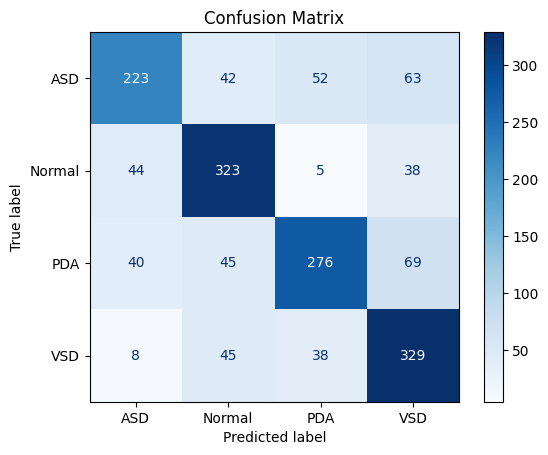

ASD: 58.68%
Normal: 78.78%
PDA: 64.19%
VSD: 78.33%


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import copy

# ===============================
# 📁 Paths
# ===============================
train_data_path = "/content/CHD_processed/train"
val_data_path = "/content/CHD_processed/val"

# ===============================
# 🔄 Transforms
# ===============================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ===============================
# 📊 Datasets and Loaders
# ===============================
train_dataset = ImageFolder(train_data_path, transform=transform)
val_dataset = ImageFolder(val_data_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# ===============================
# 🧠 Model (ResNet50 + Transfer Learning)
# ===============================
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# ===============================
# ⚙️ Training Setup
# ===============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 10

print("✅ ResNet50 ready — data loaded, model transferred to GPU.")

# ===============================
# 🔁 Training Loop with Validation
# ===============================
best_model_wts = copy.deepcopy(model.state_dict())
best_val_acc = 0.0

for epoch in range(epochs):
    model.train()
    train_true, train_pred = [], []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, 1)
        train_true.extend(labels.cpu().numpy())
        train_pred.extend(preds.cpu().numpy())

    train_acc = accuracy_score(train_true, train_pred)

    # Validation phase
    model.eval()
    val_true, val_pred = [], []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, 1)
            val_true.extend(labels.cpu().numpy())
            val_pred.extend(preds.cpu().numpy())

    val_acc = accuracy_score(val_true, val_pred)

    if val_acc > best_val_acc:
      best_val_acc = val_acc
      best_model_wts = copy.deepcopy(model.state_dict())
      torch.save(best_model_wts, "/content/drive/MyDrive/kaggle/GANs_resnet50_chd_model.pth")
      print(f"💾 Saved new best model at epoch {epoch+1} with Val Acc: {val_acc*100:.2f}%")

    print(f"Epoch {epoch+1}/{epochs} | Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")

# ===============================
# 💾 Load Best Model
# ===============================
model.load_state_dict(best_model_wts)
print("✅ Best model loaded.")

# ===============================
# 📈 Evaluation & Confusion Matrix
# ===============================
model.eval()
val_true, val_pred = [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, 1)
        val_true.extend(labels.cpu().numpy())
        val_pred.extend(preds.cpu().numpy())

# Confusion Matrix
class_names = train_dataset.classes
cm = confusion_matrix(val_true, val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()

# Per-class Accuracy
per_class_acc = cm.diagonal() / cm.sum(axis=1)
for class_name, acc in zip(class_names, per_class_acc):
    print(f"{class_name}: {acc*100:.2f}%")
